# 이전의 분석에서의 문제점
- 1번 분석파일에서 변수들의 시각화 결과를 보면 이상치도 많고 분포가 마음에 들지 않는다
- log scaling을 시도해보고 모델의 성능 결과를 비교해보려 한다.

# 0. 데이터 불러오고 확인

In [1]:
import numpy as np # linear algebra
import pandas as pd # data frame, data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn') # matplotlib 도 종류가 다양하기 때문에 seaborn 스타일로 지정한 거임.
sns.set(font_scale=1.5) # (기본으로) 폰트 크기 2.5로 지정 미리 해놓는거 2.5면 꽤 크게 나옴

import missingno as msno # missing data 잘 보여주는 라이브러리
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 
df_train = pd.read_csv('./Adv_IMC_train.csv', encoding='utf8')
df_test = pd.read_csv('./Adv_IMC_test.csv', encoding='utf8')
print(df_train.shape)
print(df_test.shape)

(1042, 12)
(261, 11)


# 1. EDA 시작

## 1.0 결측치 확인 및 제거

In [2]:
df_train.dropna(axis=0,inplace=True)
df_train.index = range(df_train.shape[0])

# test는 제거할 결측치가 없음
# df_train.dropna(axis=0,inplace=True)
# df_train.index = range(df_train.shape[0])

## 1.1 Ram 과 Weight 변수 수치화로

- 수치형 자료로 바꿔주어야할 변수들 :

Ram은 GB 없애기,
Weight는 kg 없애기,


In [3]:
# Ram은 GB 없애기
df_train['Ram'] = df_train['Ram'].apply(lambda x: x.replace('GB','')).astype('float')
df_test['Ram'] = df_test['Ram'].apply(lambda x: x.replace('GB','')).astype('float')

In [4]:
# Weight는 kg 없애기
df_train['Weight'] = df_train['Weight'].apply(lambda x: x.replace('kg','')).astype('float')
df_test['Weight'] = df_test['Weight'].apply(lambda x: x.replace('kg','')).astype('float')

## 1.2 Memory 변수

### 1.2.1 Memory의 'SSD','HDD','Hybrid','Flash Storage' 범주를 이용하여 각각에 대한 GB 단위 용량 변수 생성

- 길이가 3보다 큰 친구들은 +로 연결되어있는 친구들

- 길이가 3인 친구들은 Flash Storage인 친구들

- 길이가 2 이하인 친구들은 SSD이거나 HDD이거나 Hybrid

- length 4, 3, 2 로 저장해놓은 인덱스를 이용하여 각각의 인덱싱한 데이터프레임에 대하여 따로 함수 적용
- GB혹은 TB로 용량이 표시되어있고 뒤에 메모리의 종류가 적혀있는 구조이다.
- length 4면 +로 split한 다음 첫번째원소는 두번째원소를 변수명으로 하는 value, 세번째 원소는 네번째 원소를 변수명으로 하는 value
- length 3이면 split한 다음 첫 번째 원소만 가져오고 변수명은 Flash Storage로
- length 2면 split한 다음 첫 번째 원소를 value로 가져오고 두번째를 변수명으로(SSD, HDD, Hybrid 중에 하나)

In [5]:
# length4에 대하여
def Preprocess_MemoryColumn(df):
    # +로 연결되어있는 친구들, SSD HDD Hybrid 등 여러 가지를 가지고 있다.
    length4 = np.where(df.Memory.apply(lambda x: '+' in x))[0]
    
    GB_front = df.loc[length4,'Memory'].str.split('+').str[0].str.rstrip()
    front_name = GB_front.str.split().str[1]
    front_value = GB_front.str.split().str[0]

    for i in length4:
        c = front_name[i]
        v = front_value[i]
        if c == 'Flash':
            c = 'Flash Storage'
        if 'TB' in v:
            df.loc[i,c] = float(v.replace('TB',''))*1000
        else:
            df.loc[i,c] = float(v.replace('GB',''))

    GB_back = df.loc[length4,'Memory'].str.split('+').str[1].str.lstrip()
    back_name = GB_back.str.split().str[1]
    back_value = GB_back.str.split().str[0]

    for i in length4:
        c = back_name[i]
        v = back_value[i]
        if c == 'Flash':
            c = 'Flash Storage'
        if 'TB' in v:
            df.loc[i,c] = float(v.replace('TB',''))*1000
        else:
            df.loc[i,c] = float(v.replace('GB',''))
        
    # Memory에서 term이 3개인 샘플들 (Flash Storage인 애들)
    length3 = np.where(df.Memory.apply(lambda x: len(x.split())==3))[0]
    df.loc[length3,'Flash Storage'] = df.loc[length3,'Memory'].str.split().str[0].str.replace('GB','').astype('float')
    
    
    
    # Memory에서 term이 2개인 샘플들
    length2 = np.where(df.Memory.apply(lambda x: len(x.split())<=2))[0]
    value = df.loc[length2,'Memory'].str.split().str[0]
    name = df.loc[length2,'Memory'].str.split().str[1]
    for i in length2:
        c = name[i]
        if c == 'Flash':
            c = 'Flash Storage'
        v = value[i]
        if 'TB' in v:
            df.loc[i,c] = float(v.replace('TB',''))*1000     
        else:
            df.loc[i,c] = float(v.replace('GB',''))
    return df

df_train = Preprocess_MemoryColumn(df_train)

In [6]:
df_train = df_train.drop(['Memory'],axis=1)
df_train.loc[:,['SSD','HDD','Hybrid','Flash Storage']] = df_train.loc[:,['SSD','HDD','Hybrid','Flash Storage']].fillna(0)

In [7]:
df_test = Preprocess_MemoryColumn(df_test)
df_test = df_test.drop(['Memory'],axis=1)
df_test.loc[:,['SSD','HDD','Hybrid','Flash Storage']] = df_test.loc[:,['SSD','HDD','Hybrid','Flash Storage']].fillna(0)

## 1.3 Opsys 변수

- 별다른 문제는 없지만, test에는 없고 train에만 있는 범주가 존재함, 학습할 필요가 없다고 여겨지므로 제거하는 편이 나을듯 (train data에 9개 존재함)

In [8]:
df_train.drop(np.where((df_train.OpSys=='Android')|(df_train.OpSys=='Mac OS X'))[0],axis=0,inplace=True)
df_train.index = range(df_train.shape[0])

## 1.4 ScreenResolution 변수

### 1.4.1 우선 맨 마지막 term의 숫자x숫자를 빼내어 가로, 세로 변수를 생성하는게 좋을듯 (screen_x, screen_y)

### 1.4.2 FullHD, IPSPanel, QuadHD, Retina Display, 4K Ultra HD 등의 범주를 띄어쓰기 없애고 split하여 각각을 변수로서 생성

In [9]:
def process_ScreenResolution(df):
    size = df.ScreenResolution.str.split().str[-1].str.split('x')
    df['screen_x']=size.str[0].astype(float)
    df['screen_y']=size.str[1].astype(float)
    df.ScreenResolution = df.ScreenResolution.str.split().str[:-1].str.join(' ')
    
    from collections import Counter
    df.ScreenResolution = df.ScreenResolution.str.replace('Full HD','FullHD').str.replace('IPS Panel','IPSPanel').str.replace('Quad HD','QuadHD').str.replace('Retina Display','RetinaDisplay').str.replace('4K Ultra HD','4KUltraHD')
    screen_counter = df.ScreenResolution.str.replace('+','_plus').str.replace('/','').str.split().apply(lambda x: Counter(x))
    for i in range(df.shape[0]):
        if screen_counter[i]:
            for k,v in screen_counter[i].items():
                df.loc[i,k] = v
    return df

In [10]:
df_train = process_ScreenResolution(df_train)
df_train = df_train.drop(['ScreenResolution'],axis=1)
df_train.loc[:,['FullHD','IPSPanel','Touchscreen','4KUltraHD','RetinaDisplay','QuadHD_plus']] = df_train.loc[:,['FullHD','IPSPanel','Touchscreen','4KUltraHD','RetinaDisplay','QuadHD_plus']].fillna(0)

In [11]:
df_test = process_ScreenResolution(df_test)
df_test.drop(['ScreenResolution'],axis=1,inplace=True)
df_test.loc[:,['FullHD','IPSPanel','Touchscreen','4KUltraHD','RetinaDisplay','QuadHD_plus']] = df_test.loc[:,['FullHD','IPSPanel','Touchscreen','4KUltraHD','RetinaDisplay','QuadHD_plus']].fillna(0)

## 1.5 Gpu 변수

### 1.5.0 GPU 변수중 ARM으로 시작하는 범주가 test에는 없음을 확인, 제거해도 될듯(학습데이터에 존재하는 개수도 1개뿐임)

### 1.5.1 GPU 변수를 split하여 2번째 이후 term부터는 다 합쳐놓고 봐서 빈도수에 기반하여 너무 sparse하지 않은 텍스트만 남겨놓기로 함. (임의로 10% 정도로 기준을 잡았음)

In [12]:
def preprocess_gpu_column(df):
    noexist_test = set(df.Gpu.str.split().str[0])-set(df_test.Gpu.str.split().str[0])
    df.drop(np.where(df.Gpu.apply(lambda x: x.split()[0] in noexist_test))[0],axis=0,inplace=True)
    df.index = range(df.shape[0])
    
    from itertools import chain
    from collections import Counter
    series_gpu_split_list = list(df.Gpu.str.split())
    gpu_column_counter = Counter(list(chain(*series_gpu_split_list)))
    sorted_counter = sorted(gpu_column_counter.items(),key=lambda x: x[1], reverse=True)
    freq10 = [k for k,v in sorted_counter if (v/df.shape[0]*100>=10) and (not k.isdigit())]
    
    # 문제가 되는 부분 : GTX는 유효해보이므로 남길 것인데, GTX1060 GTX1080 등은 GTX로서 기능해야할 것이니까 제거를 바로 하면 안됨.

    # freq10 안에 존재하면 그대로 보존하고,
    # 만약 freq10 안의 어떤 단어와 비슷하다면(포함관계라면) freq10의 단어로 대체해준다.
    def exist_freq_replace(x):
        result_list = []
        for i in x:
            if i in freq10:
                result_list.append(i)
            else:
                for f in freq10:
                    if f in i:
                        result_list.append(f)
                        break
        return result_list
    
    gpu_counter = df.Gpu.str.split().apply(lambda x: Counter(exist_freq_replace(x)))

    for i in range(df.shape[0]):
        if gpu_counter[i]:
            for k,v in gpu_counter[i].items():
                df.loc[i,k] = v
    
    return df
    

In [13]:
df_train = preprocess_gpu_column(df_train)
df_train.drop(['Gpu'],axis=1,inplace=True)
df_train.fillna(0,inplace=True)

In [14]:
df_test = preprocess_gpu_column(df_test)
df_test.drop(['Gpu'],axis=1,inplace=True)
df_test.fillna(0,inplace=True)

## 1.6 Cpu 변수

### 1.6.1 Cpu_GHz 변수 생성

- CPU 같은 경우는 모두 GHz로 끝남


- 그렇다면 우선 split구분 후 맨마지막 term을 Cpu_GHz 라는 변수를 따로 만들어주자

-  series.str.split 메서드를 사용하여 이를 빠르게 처리하였습니다

### 1.6.2 CPU변수의 범주들 중 sparse하지 않다고 판단되는 유효한 term (텍스트들)만 남겨서 변수생성
- Samsung은 테스트셋에 없고 트레인셋에만 있기 때문에 삭제하였음

- 첫번째 term은 브랜드로 생각할 수 있으므로 따로 변수생성 (CpuBrand)

- 10% 이상의 빈도를 나타내는 단어들만 남기고 모두 삭제

In [15]:
def preprocess_CpuColumn(df):
    # 그렇다면 우선 split구분 후 맨마지막 term을 Cpu_GHz 라는 변수를 따로 만들어주자
    df_train_split_list = df['Cpu'].str.split(' ')
    df['Cpu_GHz'] = df_train_split_list.str[-1].str.replace('GHz','').astype('float')
    df['Cpu'] = df_train_split_list.str[:-1].str.join(' ')

    # Samsung은 테스트셋에 없고 트레인셋에만 있기 때문에 삭제하였음
    noexist_test = set(df.Cpu.str.split().str[0])-set(df_test.Cpu.str.split().str[0])
    df.drop(np.where(df.Cpu.apply(lambda x: x in noexist_test))[0],axis=0,inplace=True)
    df.index = range(df.shape[0])
    
    # 첫번째 term은 브랜드로 생각할 수 있으므로 따로 변수생성 (CpuBrand)
    df['CpuBrand']=df.Cpu.str.split().str[0]
    df['Cpu']=df.Cpu.str.split().str[1:].str.join(' ')
    
    # 10% 이상의 빈도를 나타내는 단어들만 남기고 모두 삭제
    from itertools import chain
    from collections import Counter
#     series_cpu_split_list = list(df.Cpu.str.split())
#     cpu_column_counter = Counter(list(chain(*series_cpu_split_list)))
#     sorted_counter = sorted(cpu_column_counter.items(),key=lambda x: x[1], reverse=True)
#     freq10_tr = [k for k,v in sorted_counter if (v/df.shape[0]*100>=10) and (not k.isdigit())]

    series_cpu_split_list = list(df_test.Cpu.str.split())
    cpu_column_counter = Counter(list(chain(*series_cpu_split_list)))
    sorted_counter = sorted(cpu_column_counter.items(),key=lambda x: x[1], reverse=True)
    freq10_test = [k for k,v in sorted_counter if (v/df_test.shape[0]*100>=5) and (not k.isdigit())]

#     freq10 = set(freq10_tr)&set(freq10_test)
    freq10 = freq10_test

    # freq10 안에 존재하면 그대로 보존하고,
    # 만약 freq10 안의 어떤 단어와 비슷하다면(포함관계라면) freq10의 단어로 대체해준다.
    def exist_freq_replace(x):
        result_list = []
        for i in x:
            if i in freq10:
                result_list.append(i)
            else:
                for f in freq10:
                    if f in i:
                        result_list.append(f)
                        break
        return result_list

    cpu_counter = df.Cpu.str.split().apply(lambda x: Counter(exist_freq_replace(x)))

    for i in range(df.shape[0]):
        if cpu_counter[i]:
            for k,v in cpu_counter[i].items():
                df.loc[i,k] = v

    return df

In [16]:
df_train = preprocess_CpuColumn(df_train)
df_train.drop(['Cpu'],axis=1, inplace=True)
df_train.fillna(0,inplace=True)

In [17]:
df_test = preprocess_CpuColumn(df_test)
df_test.drop(['Cpu'],axis=1, inplace=True)
df_test.fillna(0,inplace=True)

- 변수마다 살펴보면, 테스트에는 존재하지 않지만 트레인에만 있는 범주가 있음
- 사실 이러한 범주들은 훈련시킬 필요도 없으니 관측치를 제거해도 될 것이다.

In [18]:
## 테스트에는 존재하지 않는 범주들은 필요없음
noexist_dict = {} # column 명을 key값으로, test에 있지만 train에 없는 범주 set를 value로 갖는 dictionary
more_train_columns = [] # test에 더 많은 범주가 있는 column
more_test_columns = [] # test에 더 많은 범주가 있는 column
for c in [i for i in df_test.columns if df_test[i].dtypes=='object']:
    train_unique = set(df_train[c])
    test_unique = set(df_test[c])
    print(f'train의 {c} unique개수는 {len(train_unique)}, test의 {c} unique개수는 {len(test_unique)}')
    noexist_dict[c] = train_unique - test_unique
    train_test = len(train_unique-test_unique) # train 범주의 개수에서 test 범주의 개수를 뺌
    test_train = len(test_unique-train_unique) # test 멈주의 개수에서 train 범주의 개수를 뺌
    print(f'두개의 교집합 개수는 {len(train_unique&test_unique)}')
    print(f'단순 길이 차이 : {len(train_unique)-len(test_unique)}, train-test 차집합 개수 : {train_test}, test-train 차집합 개수 : {test_train}')
    print('='*30)
    if test_train>0: # test에 있지만 train에는 없는 범주가 존재하는 경우 
        more_test_columns.append(c)
    if train_test>0:
        more_train_columns.append(c)
        
print(more_train_columns) # test에 있지만 train에는 없는 범주가 존재하는 column들이다.
print(more_test_columns) # test에 있지만 train에는 없는 범주가 존재하는 column들이다.

train의 Company unique개수는 19, test의 Company unique개수는 15
두개의 교집합 개수는 15
단순 길이 차이 : 4, train-test 차집합 개수 : 4, test-train 차집합 개수 : 0
train의 Product unique개수는 527, test의 Product unique개수는 180
두개의 교집합 개수는 97
단순 길이 차이 : 347, train-test 차집합 개수 : 430, test-train 차집합 개수 : 83
train의 TypeName unique개수는 6, test의 TypeName unique개수는 6
두개의 교집합 개수는 6
단순 길이 차이 : 0, train-test 차집합 개수 : 0, test-train 차집합 개수 : 0
train의 OpSys unique개수는 7, test의 OpSys unique개수는 7
두개의 교집합 개수는 7
단순 길이 차이 : 0, train-test 차집합 개수 : 0, test-train 차집합 개수 : 0
train의 CpuBrand unique개수는 2, test의 CpuBrand unique개수는 2
두개의 교집합 개수는 2
단순 길이 차이 : 0, train-test 차집합 개수 : 0, test-train 차집합 개수 : 0
['Company', 'Product']
['Product']


- train에는 있으면서 test에는 없는 범주가 존재하는 Product와 Company => 필요없는 범주에 해당하면 train에서 샘플을 삭제하기
- test에는 있으면서 train에는 없는 범주가 있는 Product => Product 변수는 사용안하는 것이 좋아보임, 웬만하면 메꾸거나 치환하여 시도해볼만 하겠지만 430 종류나 된다. (데이터가 1000개남짓인데 말이다)
> Product 변수는 그냥 삭제하고, Company 변수에 집중하자.

In [19]:
df_train.drop(['Product'],axis=1,inplace=True)
df_test.drop(['Product'],axis=1,inplace=True)

- Company 변수

In [20]:
noexist_test=set(df_train['Company'])-set(df_test['Company'])
df_train.drop(np.where(df_train['Company'].apply(lambda x: x in noexist_test))[0],axis=0,inplace=True)
df_train.index = range(df_train.shape[0])

In [21]:
need_dumies = ['Company','CpuBrand','OpSys','TypeName']
train = pd.get_dummies(df_train, columns=need_dumies, prefix='dummy')
test = pd.get_dummies(df_test, columns=need_dumies, prefix='dummy')
train.describe()

,Inches,Ram,Weight,price,SSD,HDD,Hybrid,Flash Storage,screen_x,screen_y,...,dummy_Windows 10,dummy_Windows 10 S,dummy_Windows 7,dummy_macOS,dummy_2 in 1 Convertible,dummy_Gaming,dummy_Netbook,dummy_Notebook,dummy_Ultrabook,dummy_Workstation
count,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,...,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000
mean,15.017964,8.399202,2.043319,1131.957585,183.680639,421.784431,9.489022,2.554890,1896.956088,1070.011976,...,0.825349,0.005988,0.039920,0.010978,0.086826,0.163673,0.023952,0.554890,0.147705,0.022954
std,1.416231,5.137891,0.665085,696.644911,184.824873,506.213612,95.701012,17.345622,501.757598,286.152038,...,0.379858,0.077189,0.195869,0.104251,0.281721,0.370163,0.152976,0.497226,0.354984,0.149832
min,10.100000,2.000000,0.690000,174.000000,0.000000,0.000000,0.000000,0.000000,1366.000000,768.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,4.000000,1.500000,597.250000,0.000000,0.000000,0.000000,0.000000,1600.000000,900.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15.600000,8.000000,2.040000,979.000000,256.000000,0.000000,0.000000,0.000000,1920.000000,1080.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,15.600000,8.000000,2.307500,1499.000000,256.000000,1000.000000,0.000000,0.000000,1920.000000,1080.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,18.400000,64.000000,4.700000,5499.000000,1000.000000,2000.000000,1000.000000,256.000000,3840.000000,2160.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 2. Data Visualization

- 연속형 변수에서만 간단하게 시각화를 하고 넘어가도록 하겠다.

In [22]:
categorical_variables = df_train.columns[df_train.dtypes == 'object'].tolist()
continuous_variables = []

for c in df_train.columns[df_train.dtypes != 'object']:
    if len(set(df_train[c]))<=2:
        categorical_variables.append(c)
    else:
        continuous_variables.append(c)

continuous_variables

['Inches',
 'Ram',
 'Weight',
 'price',
 'SSD',
 'HDD',
 'Hybrid',
 'Flash Storage',
 'screen_x',
 'screen_y',
 'Cpu_GHz']

In [23]:
sns.set(font_scale=1.5) # (기본으로) 폰트 크기 2.5로 지정 미리 해놓는거 2.5면 꽤 크게 나옴

def kde_or_box_per_column(column_list,df,plot_type='kde'):
    nfeatures = len(continuous_variables)
    axes_column = 4
    axes_row = int(np.ceil(nfeatures/axes_column))

    fig, axes = plt.subplots(axes_row,axes_column, figsize=(12, 8))

    for idx in range(nfeatures):
        feature_name = continuous_variables[idx]
        r,c = idx//4,idx%4
        if plot_type=='kde':
            sns.distplot(df[feature_name], color='b', label=f'Skewness : {round(df[feature_name].skew(),2)}', ax=axes[r][c])
        elif plot_type=='box':
            sns.boxplot(data=df[feature_name], ax=axes[r][c])
        else:
            break
        axes[r,c].set_title(feature_name)
    plt.tight_layout() # plot 간 간격을 자동으로 맞춰준다.
    plt.show()

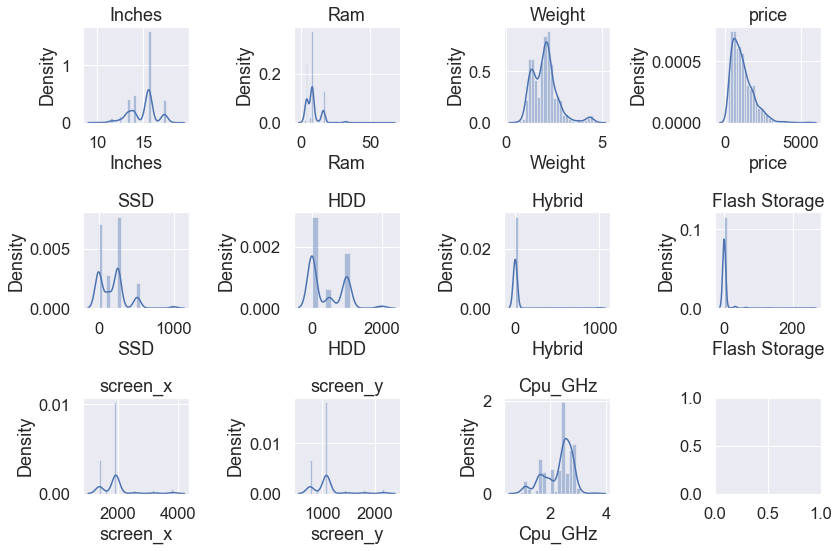

In [24]:
# kde plot
kde_or_box_per_column(column_list=continuous_variables, df=df_train, plot_type='kde')

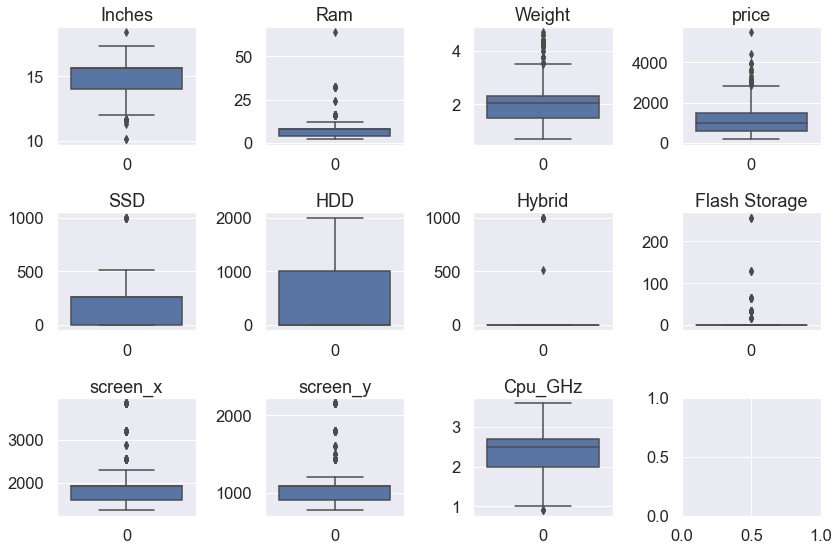

In [25]:
# boxplot
kde_or_box_per_column(column_list=continuous_variables, df=df_train, plot_type='box')

In [42]:
need_log_scaling = ['Ram','Hybrid','Flash Storage','screen_x','screen_y']

In [44]:
from copy import deepcopy
copy_train = deepcopy(df_train)
def log_scaling(x):
    return np.log(x) if x>0 else x

for c in need_log_scaling:
    copy_train[c] = copy_train[c].apply(lambda x: log_scaling(x)) 

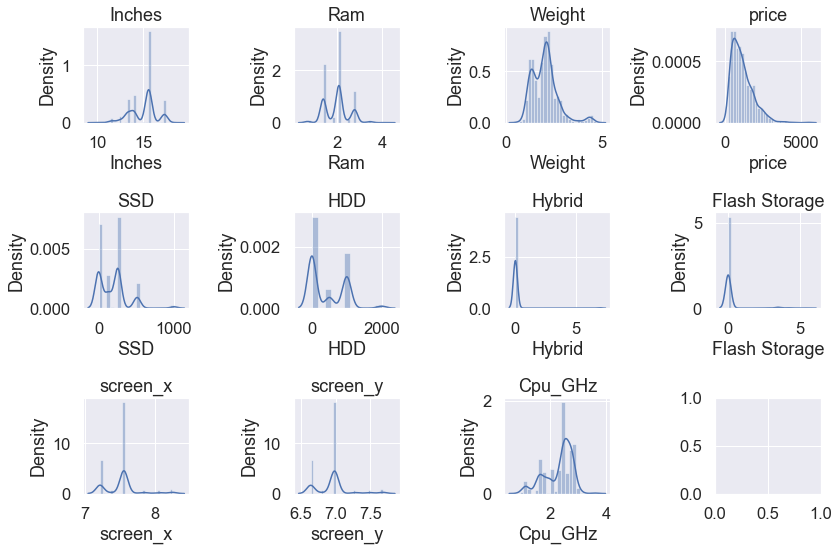

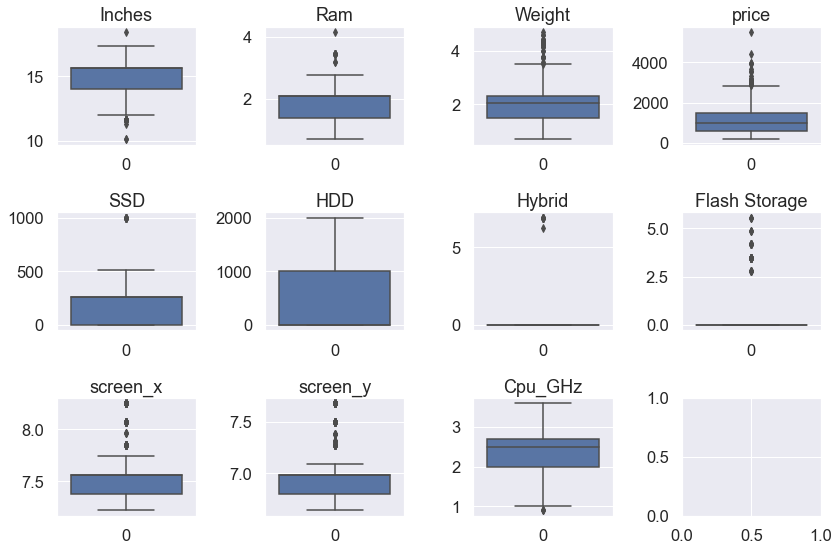

In [50]:
# log scaling 후
kde_or_box_per_column(column_list=continuous_variables, df=copy_train, plot_type='kde')
kde_or_box_per_column(column_list=continuous_variables, df=copy_train, plot_type='box')


In [57]:
df_train = copy_train

# 3. Modeling

## 3.1 XGB and LGBM

In [58]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


In [59]:
X = train.drop('price', axis=1)
y = train['price']
X_test = test
# split dataframe into X & Y
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
def print_best_params(model, params):
    cv=5
    grid_model = GridSearchCV(
        model, 
        param_grid = params,
        cv=cv,
        scoring='neg_mean_squared_error',
        verbose=0)

    grid_model.fit(X, y,verbose=0)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(f'{model.__class__.__name__} {cv} CV 시 최적 평균 RMSE 값 {np.round(rmse, 4)}, 최적 Parameters:{grid_model.best_params_}')
    return grid_model.best_estimator_


In [61]:
xgb_params ={
    'learning_rate': [1e-3,3e-3,1e-2,0.05],
    'max_depth': [3,4,5],
    'subsample': [0.5,0.7,0.9],
    'colsample_bytree': [0.5,0.7,0.9],
    'n_estimators':[1000],
    'random_state':[0]
#     'silent': [True],
#     'gpu_id':[1] ,         
#     'tree_method':['hist','gpu_hist'],
#     'predictor':['gpu_predictor'],
#     'refit' : [True]
}
# xgb_params = {'colsample_bytree': [0.7], 'learning_rate': [0.05], 'max_depth': [3], 'n_estimators': [1000], 'subsample': [0.9]}
xgb_model = XGBRegressor()
xgb_estimator = print_best_params(xgb_model, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값 262.5933, 최적 Parameters:{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000, 'random_state': 0, 'subsample': 0.9}


In [ ]:
# log scaling 전의 XGB 5CV결과 RMSE : 262.5933
# 최적 Parameters:{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000, 'refit': True, 'silent': True, 'subsample': 0.9}

# log scaling 후의 XGB 5CV결과 RMSE :


In [64]:
lgb_params = {
    'bagging_fraction':[0.5,0.7,0.9],
    'feature_fraction':[0.5,0.7,0.9],
    'objective':['regression'],
    'boosting':['gbdt','dart'],
    'num_leaves' : [31], # default = 31
    'learning_rate' : [1e-2,0.05],
    'n_estimators':[1000,5000],
    'max_bin' : [255],
    'verbosity':[0],
    'random_state':[0]
#     'gpu_id':[0] ,         
#     'refit':[True],
}
lgb_params = {'bagging_fraction': [0.5], 'boosting': ['dart'], 'feature_fraction': [0.5], 'learning_rate': [0.05], 'max_bin': [255], 'n_estimators': [5000], 'num_leaves': [31], 'objective': ['regression']}
lgb_model = LGBMRegressor()
lgb_estimator = print_best_params(lgb_model, lgb_params)


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will b

In [ ]:
# log scaling 이전의 LGBM 5CV결과 RMSE : 287.2203
# 최적 Parameters:{'bagging_fraction': 0.5, 'boosting': 'dart', 'feature_fraction': 0.5, 'gpu_id': 0, 'learning_rate': 0.05, 'max_bin': 255, 'n_estimators': 5000, 'num_leave': -1, 'objective': 'regression'}

# scaling 이후 287.3793
# 최적 Parameters:{'bagging_fraction': 0.5, 'boosting': 'dart', 'feature_fraction': 0.5, 'learning_rate': 0.05, 'max_bin': 255, 'n_estimators': 5000, 'num_leaves': 31, 'objective': 'regression', 'random_state': 0, 'verboseity': 0}

### What's the meaning of "No further splits with positive gain, best gain: -inf" message?

- That is, LGB is trying to split the data in leaf but it can't. The greater min_data_in_leaf is the more conservative the algorithm is. Its optimal value depends on the number of training samples and num_leaves.


- It means the learning of tree in current iteration should be stop, due to cannot split any more. I think this is caused by "min_data_in_leaf":1000, you can set it to a smaller value.

- You're right, it is not a loop. It just appeared as if it was, because the number of trees was high. So in case such a message appears, it might be usefull to check n_estimators or the parameters for the number of maximum leafes in a tree or the data parameters like min data in leaf, or min gain etc

출처 : https://datascience.stackexchange.com/questions/66902/what-does-the-repeated-message-no-further-splits-with-positive-gain-best-gain/89151#89151

### 2.2 Catboost

In [63]:
def cat_cv_best_params(model, params):
    cv=5
    grid_model = GridSearchCV(
        model, 
        param_grid = params,
        cv=cv,
        scoring='neg_mean_squared_error',
        verbose=0)

    grid_model.fit(X.values, y.values,verbose=0)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(f'{model.__class__.__name__} {cv} CV 시 최적 평균 RMSE 값 {np.round(rmse, 4)}, 최적 Parameters:{grid_model.best_params_}')
    return grid_model.best_estimator_


from catboost import CatBoostRegressor
cat_params = {
            "iterations": [1000], # default=1000
            "depth": [6], # default=6
            "loss_function": ["RMSE"],
            "verbose": [False],
            "learning_rate":[1e-2,3e-2,0.1],
            "rsm":[0.5,0.7,0.9], # Alias: "colsample_bylevel"
            "subsample":[0.5,0.7,0.9]
}

cat_params = {'depth': [6], 'iterations': [1000], 'learning_rate': [0.03], 'loss_function': ['RMSE'], 'rsm': [0.7], 'subsample': [0.7], 'verbose': [False]}

cat_model = CatBoostRegressor()
cat_estimator = cat_cv_best_params(cat_model, cat_params)


CatBoostRegressor 5 CV 시 최적 평균 RMSE 값 269.2121, 최적 Parameters:{'depth': 6, 'iterations': 1000, 'learning_rate': 0.03, 'loss_function': 'RMSE', 'rsm': 0.7, 'subsample': 0.7, 'verbose': False}


In [54]:
# log scaling 이전의 RMSE 값 269.2121, 
# 최적 Parameters:{'depth': 6, 'iterations': 1000, 'learning_rate': 0.03, 'loss_function': 'RMSE', 'rsm': 0.7, 'subsample': 0.7, 'verbose': False}

# log scaling 이후 RMSE 값 269.2121, 
# 최적 Parameters:{'depth': 6, 'iterations': 1000, 'learning_rate': 0.03, 'loss_function': 'RMSE', 'rsm': 0.7, 'subsample': 0.7, 'verbose': False}

## 2.3 Feature Importance Visualization

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn') # matplotlib 도 종류가 다양하기 때문에 seaborn 스타일로 지정한 거임.
sns.set(font_scale=1) # (기본으로) 폰트 크기 2.5로 지정 미리 해놓는거 2.5면 꽤 크게 나옴

%matplotlib inline 

def plot_feature_importance(model_result,feature_names,model_title,nfeatures):

    feature_importance = np.array(model_result.feature_importances_)
    feature_names = np.array(feature_names)
    
    df_feature_importance = pd.DataFrame(feature_importance, index = feature_names, columns=['importnace_values']).iloc[:nfeatures]

    df_feature_importance.sort_values(by=['importnace_values'], ascending=False,inplace=True)
    
    plt.figure(figsize=(5,4))
    #Plot Searborn bar chart
    sns.barplot(x=df_feature_importance['importnace_values'], y=df_feature_importance.index)
    #Add chart labels
    plt.title(f'{model_title} Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

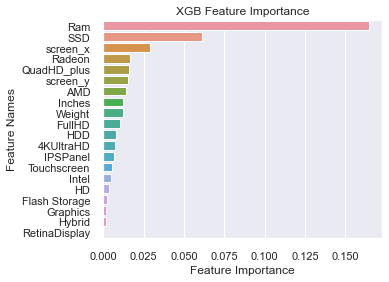

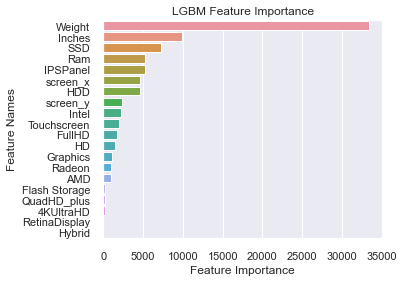

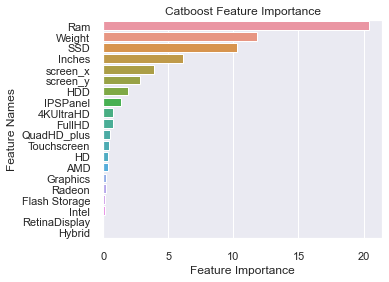

In [119]:
model_types = ['XGB','LGBM','Catboost']    
model_names = [xgb_estimator,lgb_estimator,cat_estimator]

for model_title,model_result in zip(model_types, model_names):
    plot_feature_importance(model_result=model_result, feature_names=X.columns, model_title=model_title, nfeatures=20)

In [55]:
y.describe()

count    1002.000000
mean     1131.957585
std       696.644911
min       174.000000
25%       597.250000
50%       979.000000
75%      1499.000000
max      5499.000000
Name: price, dtype: float64

In [56]:
test = test.loc[:,X.columns]
all(X.columns==test.columns)

True

In [57]:
xgb_preds = xgb_estimator.predict(test)
lgb_preds = lgb_estimator.predict(test)
cat_preds = cat_estimator.predict(test.values)

# 다음과 같이 평균을 내어 앙상블을 할 수 있다.
preds = 0.4* xgb_preds + 0.2*lgb_preds + 0.4*cat_preds
pd.DataFrame(preds,columns=['price'])
# 참고 : https://www.kaggle.com/janged/xgb-lgb

,price
0,1235.103537
1,1192.496179
2,437.452871
3,947.582444
4,1236.468603
...,...
256,1309.373746
257,1026.608137
258,3778.830302
259,2125.556017


In [58]:
pd.DataFrame(preds,columns=['price']).to_csv('1st_prediction_ensemble_xgb_lgbm_cat.csv',header=True,index=False)

In [59]:
pd.read_csv('1st_prediction_ensemble_xgb_lgbm_cat.csv')

,price
0,1235.103537
1,1192.496179
2,437.452871
3,947.582444
4,1236.468603
...,...
256,1309.373746
257,1026.608137
258,3778.830302
259,2125.556017
